In [1]:
#아래부터는 3개의 output feature에 대한 QNN예측코드

# Input Feature 1 : Difference in CO2 Mass (CO2 Mass of Swing Injection - CO2 Mass of Continuous Injection)

# Input Feature 2 : Difference in Mass of CO2 in Aqueous Phase

# Input Feature 3 : Difference in Solid Salt Mass 


Epoch 1/100
Train Loss: 0.0284, Test Loss: 0.0212
R² Score (Feature 1): -0.1916
R² Score (Feature 2): -2.9365
R² Score (Feature 3): -0.8763
qlayer.weights1 - Mean: 3.0467, Std: 1.8940
qlayer.weights2 - Mean: 2.9361, Std: 1.7401

Epoch 2/100
Train Loss: 0.0182, Test Loss: 0.0162
R² Score (Feature 1): 0.1456
R² Score (Feature 2): -1.3225
R² Score (Feature 3): -0.3344
qlayer.weights1 - Mean: 3.0427, Std: 1.9072
qlayer.weights2 - Mean: 2.9479, Std: 1.7423

Epoch 3/100
Train Loss: 0.0139, Test Loss: 0.0136
R² Score (Feature 1): 0.3634
R² Score (Feature 2): -0.7657
R² Score (Feature 3): -0.0930
qlayer.weights1 - Mean: 3.0312, Std: 1.9315
qlayer.weights2 - Mean: 2.9534, Std: 1.7384

Epoch 4/100
Train Loss: 0.0113, Test Loss: 0.0121
R² Score (Feature 1): 0.4235
R² Score (Feature 2): -0.3173
R² Score (Feature 3): 0.0304
qlayer.weights1 - Mean: 3.0116, Std: 1.9482
qlayer.weights2 - Mean: 2.9558, Std: 1.7339

Epoch 5/100
Train Loss: 0.0097, Test Loss: 0.0108
R² Score (Feature 1): 0.4815
R² Score

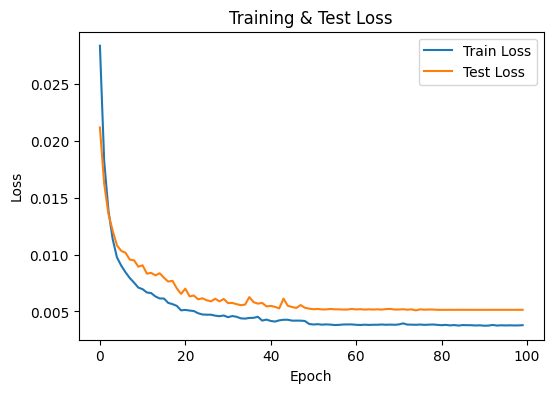

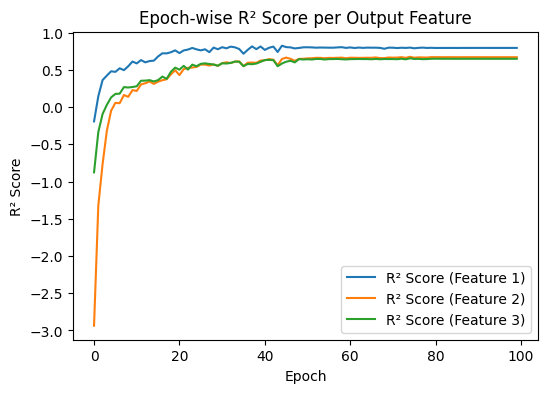

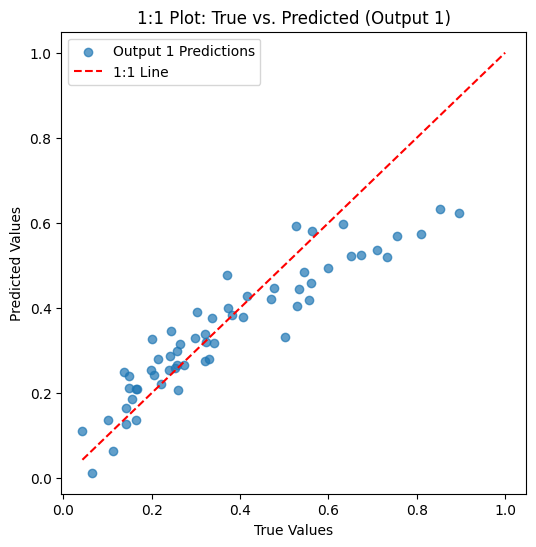

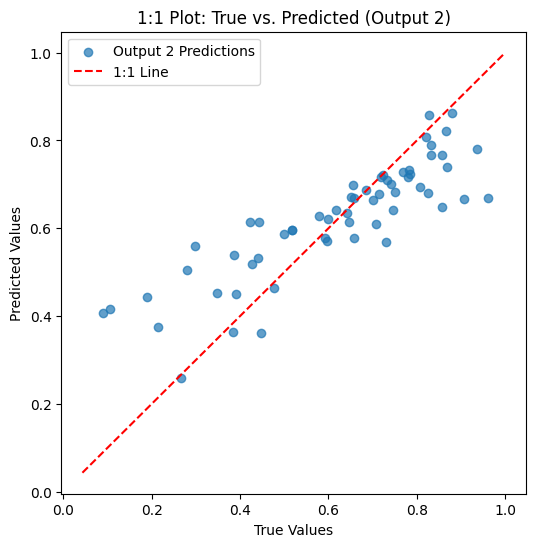

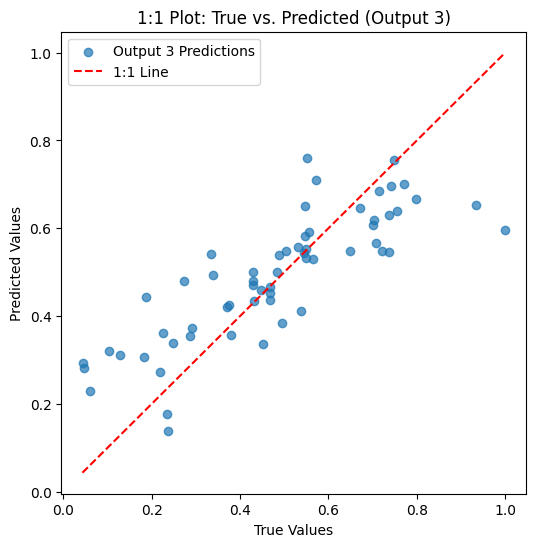


Final R² Scores for Each Output Feature:
Feature 1: 0.7953
Feature 2: 0.6707
Feature 3: 0.6493


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pennylane as qml
from sklearn.metrics import r2_score
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Data Loading
input_file = './input.xlsx'
output_file = './output.xlsx'

input_data = pd.read_excel(input_file).values
output_data = pd.read_excel(output_file).values 

X = torch.tensor(input_data, dtype=torch.float32)
y = torch.tensor(output_data, dtype=torch.float32)

split = int(0.8 * len(X))
x_train, x_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# QNN Model Define
n_qubits = 6  
q_depth = 5   
output_dim = 3  
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def qnode(inputs, weights1, weights2):  
   
    qml.templates.QAOAEmbedding(inputs, weights=weights1, wires=range(n_qubits))  
    qml.templates.StronglyEntanglingLayers(weights2, wires=range(n_qubits))  
    
    return [qml.expval(qml.Z(i)) for i in range(output_dim)]  


weight_shapes = {
    "weights1": (q_depth, 2 * n_qubits),  
    "weights2": (q_depth, n_qubits, 3)   
}

qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

class PureQNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer = qlayer  

    def forward(self, x):
        return self.qlayer(x)  

model = PureQNN()
optimizer = optim.AdamW(model.parameters(), lr=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
criterion = nn.HuberLoss(delta=0.1)  

epochs = 100
batch_size = 10
train_losses = []
test_losses = []
r2_scores_per_feature = [[] for _ in range(output_dim)] 

for epoch in range(epochs):
    model.train()
    perm = torch.randperm(len(x_train))  
    running_loss = 0

    for i in range(0, len(x_train), batch_size):
        indices = perm[i:i + batch_size]
        x_batch, y_batch = x_train[indices], y_train[indices]

        optimizer.zero_grad()
        y_pred = model(x_batch)  
        loss = criterion(y_pred, y_batch)  
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / (len(x_train) / batch_size)
    train_losses.append(avg_train_loss)

    model.eval()
    with torch.no_grad():
        y_test_pred = model(x_test)
        test_loss = criterion(y_test_pred, y_test).item()  
        test_losses.append(test_loss)

    scheduler.step(test_loss)  

   
    y_pred_final = y_test_pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    
    r2_per_feature = r2_score(y_test_np, y_pred_final, multioutput='raw_values')  
    for i in range(output_dim):
        r2_scores_per_feature[i].append(r2_per_feature[i])

 
    print(f"\nEpoch {epoch + 1}/{epochs}")
    print(f"Train Loss: {avg_train_loss:.4f}, Test Loss: {test_loss:.4f}")
    for i in range(output_dim):
        print(f"R² Score (Feature {i+1}): {r2_per_feature[i]:.4f}")
    
    for name, param in model.named_parameters():
        print(f"{name} - Mean: {param.mean().item():.4f}, Std: {param.std().item():.4f}")

plt.figure(figsize=(6, 4))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Test Loss")
plt.show()

plt.figure(figsize=(6, 4))
for i in range(output_dim):
    plt.plot(r2_scores_per_feature[i], label=f"R² Score (Feature {i+1})")
plt.xlabel("Epoch")
plt.ylabel("R² Score")
plt.title("Epoch-wise R² Score per Output Feature")
plt.legend()
plt.show()

with torch.no_grad():
    y_pred_final = model(x_test).cpu().numpy()
    y_test_np = y_test.cpu().numpy()

for i in range(output_dim):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test_np[:, i], y_pred_final[:, i], alpha=0.7, label=f"Output {i+1} Predictions")
    plt.plot([y_test_np.min(), y_test_np.max()], [y_test_np.min(), y_test_np.max()], 'r--', label="1:1 Line")
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title(f"1:1 Plot: True vs. Predicted (Output {i+1})")
    plt.legend()
    plt.show()

print("\nFinal R² Scores for Each Output Feature:")
for i in range(output_dim):
    print(f"Feature {i+1}: {r2_scores_per_feature[i][-1]:.4f}")


Basic Circuit Diagram (Text)
0: ─╭QAOAEmbedding─╭StronglyEntanglingLayers(M0)─╭StronglyEntanglingLayers(M1)─┤  <Z>
1: ─├QAOAEmbedding─├StronglyEntanglingLayers(M0)─├StronglyEntanglingLayers(M1)─┤  <Z>
2: ─├QAOAEmbedding─├StronglyEntanglingLayers(M0)─├StronglyEntanglingLayers(M1)─┤  <Z>
3: ─├QAOAEmbedding─├StronglyEntanglingLayers(M0)─├StronglyEntanglingLayers(M1)─┤     
4: ─├QAOAEmbedding─├StronglyEntanglingLayers(M0)─├StronglyEntanglingLayers(M1)─┤     
5: ─╰QAOAEmbedding─╰StronglyEntanglingLayers(M0)─╰StronglyEntanglingLayers(M1)─┤     

M0 = 
[[[0.55142833 0.25559755 0.07208601]
  [0.77968902 0.09224043 0.83174754]
  [0.53830889 0.11958901 0.98812682]
  [0.06174559 0.18543073 0.86114838]
  [0.90825669 0.74408727 0.45308122]
  [0.10098866 0.78904756 0.70093466]]]
M1 = 
[[[0.57445543 0.81948722 0.98467205]
  [0.54857926 0.40796054 0.69922212]
  [0.6159724  0.21323736 0.49394701]
  [0.2074339  0.34644127 0.65976445]
  [0.92460883 0.8023352  0.46402568]
  [0.51881216 0.75120654 0.366095

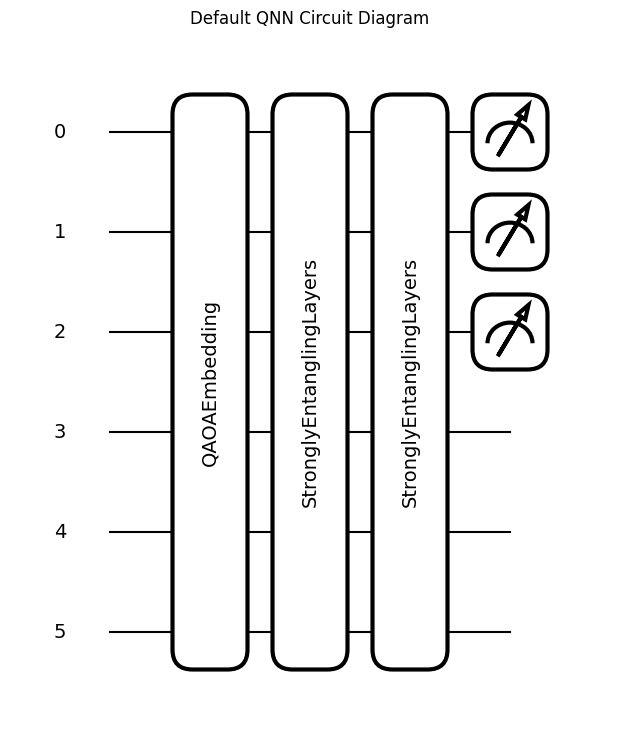

Expanded Circuit Diagram (Pennylane)
0: ──RX(0.16)─╭MultiRZ(0.01)────────────────────────────────────────────────────────────
1: ──RX(0.61)─╰MultiRZ(0.01)─╭MultiRZ(0.51)─────────────────────────────────────────────
2: ──RX(0.09)────────────────╰MultiRZ(0.51)─╭MultiRZ(0.74)──────────────────────────────
3: ──RX(0.55)───────────────────────────────╰MultiRZ(0.74)─╭MultiRZ(0.06)───────────────
4: ──RX(0.60)──────────────────────────────────────────────╰MultiRZ(0.06)─╭MultiRZ(0.85)
5: ──RX(0.81)─────────────────────────────────────────────────────────────╰MultiRZ(0.85)

──╭MultiRZ(0.17)──RY(0.37)──RX(0.16)──Rot(0.55,0.26,0.07)─╭●─────────────╭X──Rot(0.57,0.82,0.98)─╭●
──│───────────────RY(0.94)──RX(0.61)──Rot(0.78,0.09,0.83)─╰X─╭●──────────│───Rot(0.55,0.41,0.70)─╰X
──│───────────────RY(0.74)──RX(0.09)──Rot(0.54,0.12,0.99)────╰X─╭●───────│───Rot(0.62,0.21,0.49)───
──│───────────────RY(0.89)──RX(0.55)──Rot(0.06,0.19,0.86)───────╰X─╭●────│───Rot(0.21,0.35,0.66)───
──│───────────────RY(0.62)──

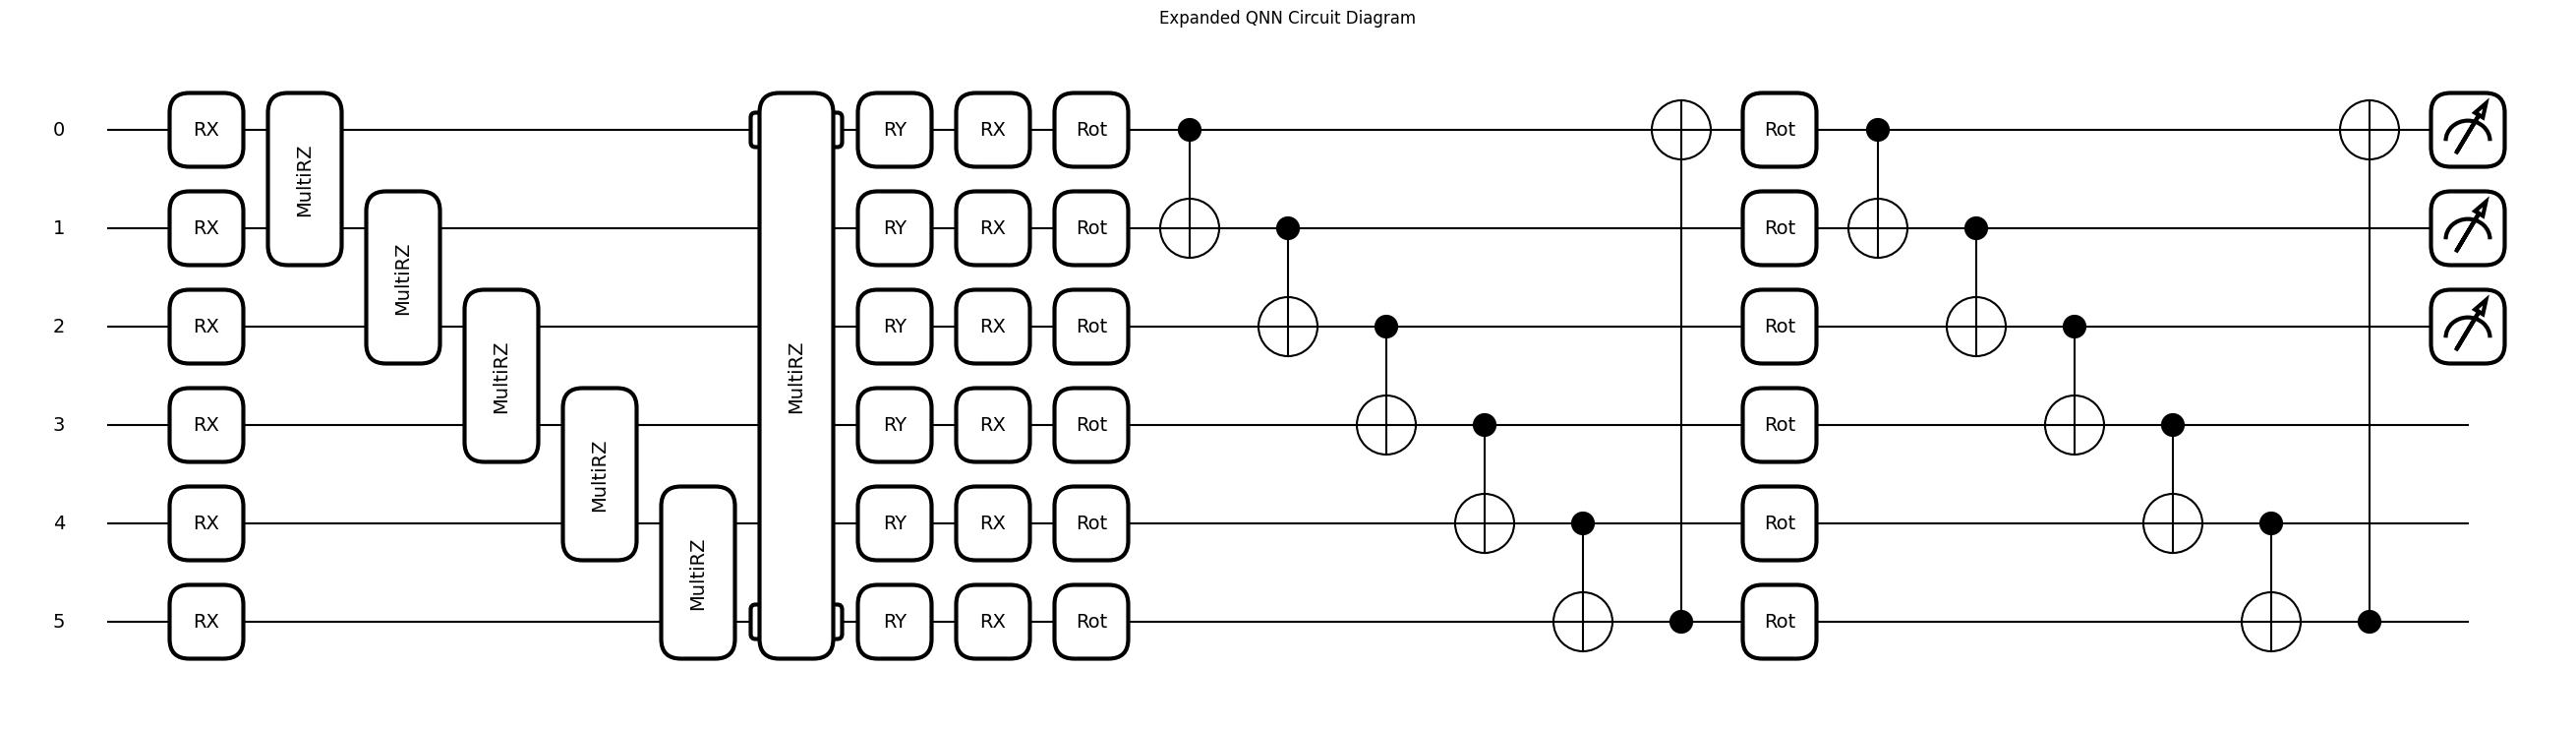

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml

n_qubits = 6
q_depth = 1
output_dim = 3
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def qnode(inputs, weights1, weights2, weights3):

    qml.templates.QAOAEmbedding(inputs, weights=weights1, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights2, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights3, wires=range(n_qubits))
    return [qml.expval(qml.Z(i)) for i in range(output_dim)]

ex_inputs   = np.random.random(n_qubits)
ex_weights1 = np.random.random((q_depth, 2 * n_qubits))
ex_weights2 = np.random.random((q_depth, n_qubits, 3))
ex_weights3 = np.random.random((q_depth, n_qubits, 3))

# Basic Circuit Diagram (Text)
print("Basic Circuit Diagram (Text)")
default_diagram = qml.draw(qnode)(ex_inputs, ex_weights1, ex_weights2, ex_weights3)
print(default_diagram)

fig_default = qml.draw_mpl(qnode)(ex_inputs, ex_weights1, ex_weights2, ex_weights3)
plt.title("Default QNN Circuit Diagram")
plt.show()

# Expanded Circuit Diagram (Pennylane)
expanded_qnode = qml.transforms.decompose(qnode)

print("Expanded Circuit Diagram (Pennylane)")
expanded_diagram = qml.draw(expanded_qnode)(ex_inputs, ex_weights1, ex_weights2, ex_weights3)
print(expanded_diagram)

fig_expanded = qml.draw_mpl(expanded_qnode)(ex_inputs, ex_weights1, ex_weights2, ex_weights3)
plt.title("Expanded QNN Circuit Diagram")
plt.show()


In [ ]:
# IBM Quantum Computer

In [ ]:
from qiskit_ibm_provider import IBMProvider

IBMProvider.save_account('Your IBM Quantum API Token', overwrite=True)

/var/folders/gv/chbzglqd3370hxv4_5m1x7b80000gn/T/ipykernel_39610/1870985311.py:1: DeprecationWarning: The package qiskit_ibm_provider is being deprecated. Please see https://docs.quantum.ibm.com/api/migration-guides/qiskit-runtime to get instructions on how to migrate to qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  from qiskit_ibm_provider import IBMProvider


In [ ]:
from qiskit_ibm_provider import IBMProvider

provider = IBMProvider()
print(provider.backends())

[<IBMBackend('ibm_yonsei')>, <IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_sherbrooke')>, <IBMBackend('ibm_kyiv')>]


In [1]:
import numpy as np
import pandas as pd
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Estimator
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.algorithms import NeuralNetworkRegressor
from qiskit_algorithms.optimizers import COBYLA
from qiskit.circuit import ParameterVector

input_file = "/Users/woojong/Documents/Geofluid/1_Research/7_학회/25-Brookhaven National Lab/QNN_Paper/input.xlsx"
output_file = "/Users/woojong/Documents/Geofluid/1_Research/7_학회/25-Brookhaven National Lab/QNN_Paper/output.xlsx"

X = pd.read_excel(input_file).values  
y = pd.read_excel(output_file).values  

service = QiskitRuntimeService(channel="ibm_quantum")

backend = service.backend("ibm_yonsei")

input_params = ParameterVector("x", length=6)
weight_params = ParameterVector("theta", length=6)

qc = QuantumCircuit(6)

for i in range(6):
    qc.u(input_params[i], -np.pi/2, np.pi/2, i)  

for i in range(6):
    qc.u(weight_params[i], 0, 0, i)

qc.cx(0, 1)
qc.cx(2, 3)
qc.cx(4, 5)

qc_transpiled = transpile(qc, backend)

with Session(backend=backend) as session:
    estimator = Estimator(session=session)

    qnn = EstimatorQNN(
        circuit=qc_transpiled, 
        estimator=estimator, 
        input_params=input_params, 
        weight_params=weight_params
    )

    regressor = NeuralNetworkRegressor(qnn, optimizer=COBYLA())

    regressor.fit(X, y)

    y_pred = regressor.predict(X)
    print("Prediction Result:", y_pred)

    rmse = np.sqrt(np.mean((y - y_pred) ** 2))
    print(f"RMSE: {rmse:.5f}")

/var/folders/gv/chbzglqd3370hxv4_5m1x7b80000gn/T/ipykernel_96538/3203246599.py:38: DeprecationWarning: The 'session' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  estimator = Estimator(session=session)
No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


ValueError: cannot reshape array of size 891 into shape (297,1)

/var/folders/gv/chbzglqd3370hxv4_5m1x7b80000gn/T/ipykernel_96538/100766619.py:48: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator_instance = Estimator()
/var/folders/gv/chbzglqd3370hxv4_5m1x7b80000gn/T/ipykernel_96538/100766619.py:51: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(


학습 시작: 출력 1번째
학습 시작: 출력 2번째
학습 시작: 출력 3번째
Prediction Result: [[0.41050137 0.57966421 0.57966421]
 [0.16559713 0.23383779 0.23383779]
 [0.29342113 0.41433657 0.41433657]
 [0.29182391 0.41208115 0.41208115]
 [0.34039823 0.48067238 0.48067238]
 [0.26835397 0.37893952 0.37893952]
 [0.19186334 0.27092799 0.27092799]
 [0.26877226 0.37953018 0.37953018]
 [0.18730677 0.26449371 0.26449371]
 [0.43222062 0.61033372 0.61033372]
 [0.20335745 0.2871587  0.2871587 ]
 [0.37753577 0.53311388 0.53311388]
 [0.52946761 0.74765506 0.74765506]
 [0.20714388 0.29250547 0.29250547]
 [0.28780054 0.4063998  0.4063998 ]
 [0.19143108 0.27031761 0.27031761]
 [0.16436839 0.2321027  0.2321027 ]
 [0.20235007 0.28573618 0.28573618]
 [0.3216954  0.45426233 0.45426233]
 [0.277661   0.39208187 0.39208187]
 [0.19559434 0.27619649 0.27619649]
 [0.29833804 0.42127968 0.42127968]
 [0.10531298 0.14871123 0.14871123]
 [0.25010859 0.35317543 0.35317543]
 [0.18624984 0.26300124 0.26300124]
 [0.28849256 0.40737699 0.40737699]
 [0

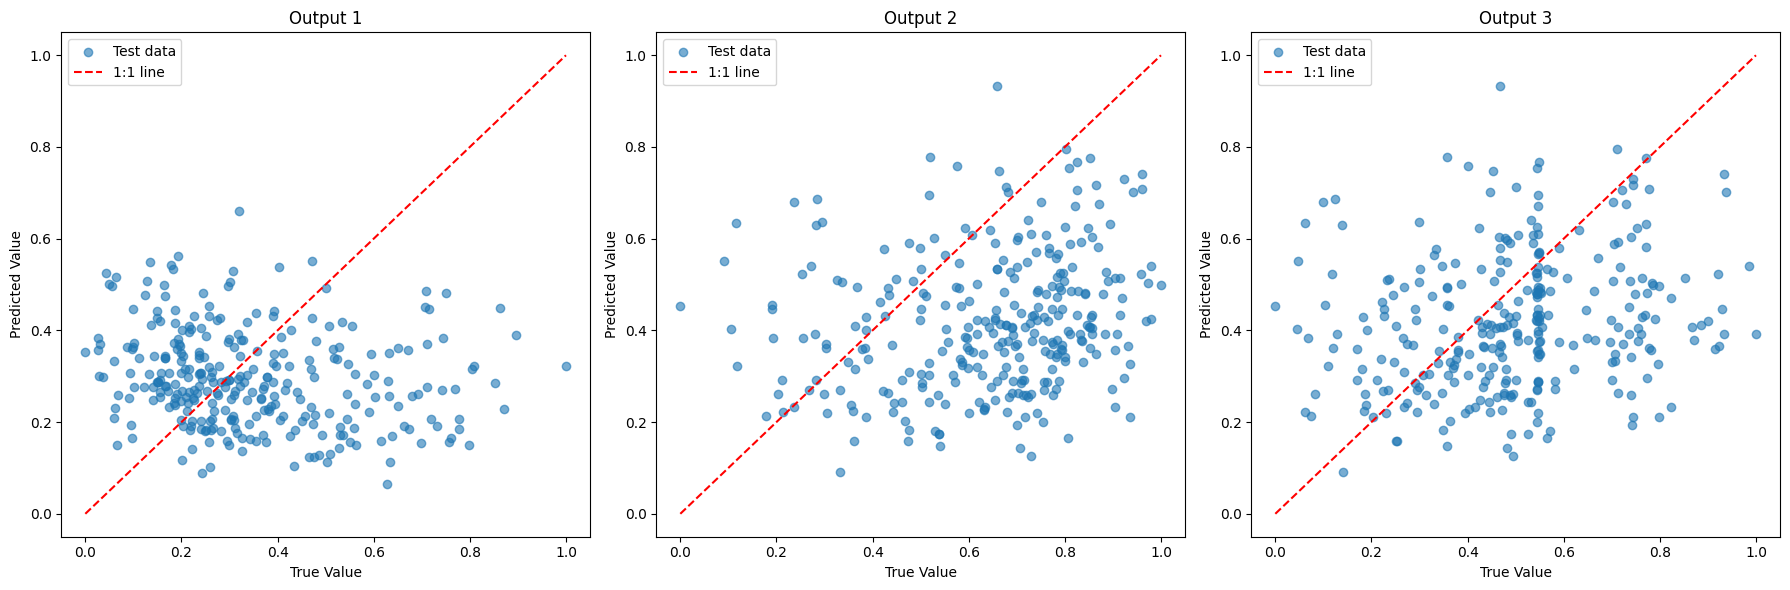

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.circuit import ParameterVector
from qiskit.primitives import Estimator
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.algorithms import NeuralNetworkRegressor
from qiskit_algorithms.optimizers import COBYLA
from qiskit.quantum_info import SparsePauliOp

input_file = "/Users/woojong/Documents/Geofluid/1_Research/7_학회/25-Brookhaven National Lab/QNN_Paper/input.xlsx"
output_file = "/Users/woojong/Documents/Geofluid/1_Research/7_학회/25-Brookhaven National Lab/QNN_Paper/output.xlsx"

X = pd.read_excel(input_file).values
y = pd.read_excel(output_file).values

backend = Aer.get_backend("aer_simulator_statevector")

n_qubits = 6
input_params = ParameterVector("x", length=n_qubits)
weight_params = ParameterVector("theta", length=n_qubits)

qc = QuantumCircuit(n_qubits)
for i in range(n_qubits):
    qc.rx(input_params[i], i)
for i in range(n_qubits):
    qc.ry(weight_params[i], i)
qc.cx(0, 1)

qc_transpiled = transpile(qc, backend)

qnn_models = []
regressors = []

operators = []
for i in range(3):

    pauli_str = "I" * n_qubits
    pauli_list = list(pauli_str)

    pauli_list[-(i+1)] = "Z"
    pauli_str_modified = "".join(pauli_list)
    op = SparsePauliOp(pauli_str_modified)
    operators.append(op)

estimator_instance = Estimator()

for op in operators:
    qnn = EstimatorQNN(
        circuit=qc_transpiled,
        input_params=input_params,
        weight_params=weight_params,
        estimator=estimator_instance
    )
    regressor = NeuralNetworkRegressor(qnn, optimizer=COBYLA())
    qnn_models.append(qnn)
    regressors.append(regressor)

num_samples = X.shape[0]
predictions = []

for i in range(3):
    y_i = y[:, i:i+1]
    print(f"학습 시작: 출력 {i+1}번째")
    regressors[i].fit(X, y_i)
    pred_i = regressors[i].predict(X) 
    predictions.append(pred_i)

y_pred = np.hstack(predictions)
print("Prediction Result:", y_pred)

rmse = np.sqrt(np.mean((y - y_pred) ** 2))
print(f"RMSE: {rmse:.5f}")


fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, ax in enumerate(axes):

    ax.scatter(y[:, i], y_pred[:, i], label='Test data', alpha=0.6)

    min_val = min(np.min(y[:, i]), np.min(y_pred[:, i]))
    max_val = max(np.max(y[:, i]), np.max(y_pred[:, i]))
    ax.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='1:1 line')
    ax.set_xlabel('True Value')
    ax.set_ylabel('Predicted Value')
    ax.set_title(f'Output {i+1}')
    ax.legend()
plt.tight_layout()
plt.show()
